In [1]:
pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'PASTE YOUR API KEY HERE'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2016-12-30,WMT,67.742045
1,2016-12-29,WMT,67.879254
2,2016-12-28,WMT,67.928257
3,2016-12-27,WMT,68.310482
4,2016-12-23,WMT,68.153672


In [3]:
# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2014-01-02  19.116238  12.726742  24.266002  150.10  71.343743
2014-01-03  19.107861  12.784441  24.248354  149.56  71.108673
2014-01-06  19.132992  12.842140  24.054226  147.00  70.710863
2014-01-07  19.334039  12.677286  24.080698  149.36  70.927850
2014-01-08  19.132992  12.809169  24.010106  151.28  70.367299

In [4]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 100000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]
df.head()

,Returns,Volatility,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.038660,0.151507,0.013147,0.286039,0.236643,0.084634,0.379536
1,0.035139,0.146466,0.216194,0.319414,0.099515,0.041203,0.323674
2,0.071166,0.157132,0.180592,0.213771,0.245773,0.160544,0.199320
3,0.069082,0.162681,0.370789,0.322337,0.166396,0.105199,0.035279
4,0.047426,0.156099,0.343773,0.368256,0.043867,0.070947,0.173157


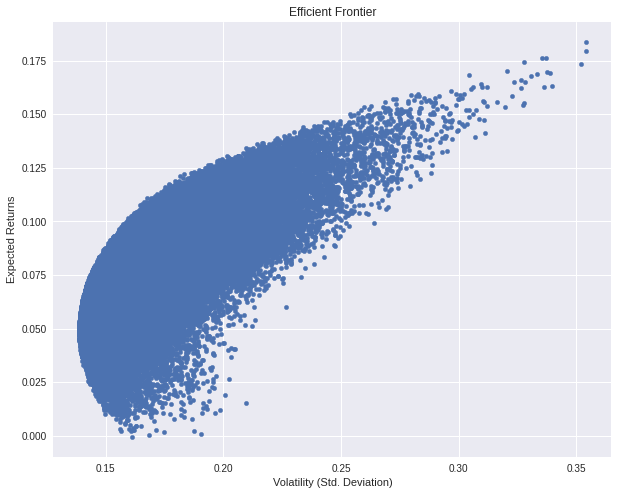

In [5]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()